# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for random $k$-regular graphs with $k=8$.

Compare the steady-state magnetization with its equilibrium value.

In [95]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [168]:
T = 25         # final time
k = 8          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.2
h = 0.0;

In [169]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [170]:
matrix_sizes = [5, 10, 25]
maxiters = [50, 50, 50]
iters = zeros(Int, length(maxiters))
tol = 5e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 39 	 Time: 1:21:51
  Δ:  8.616756089101337e-5

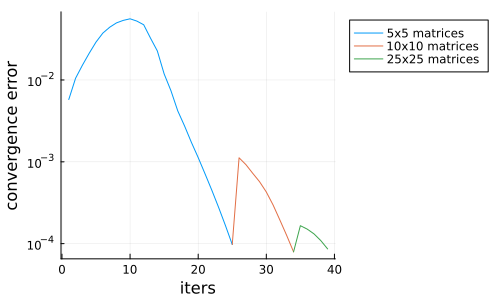

In [171]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [172]:
spin(x, i) = 3-2x
m = only(means(spin, bp));

In [173]:
m_eq = equilibrium_magnetization(RandomRegular(k), J; β, h);

In [174]:
err = abs(m[end]-m_eq)/abs(m_eq)

5.085473188203818e-9

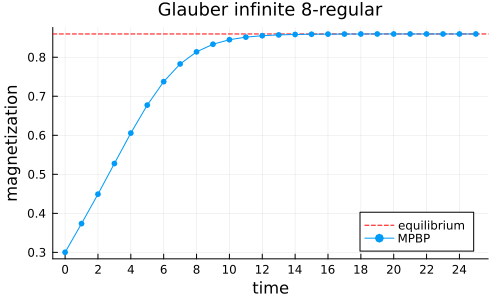

In [307]:
blue = theme_palette(:auto)[1]
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium")
pl = plot!(pl, 0:T, m, m=:o, xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
    legend=:bottomright, msc=:auto, c=blue)


# ylims = m_eq .+ 1e-3 .* (-1,1)
# plot!(pl, xticks=14:2:T, ylims=ylims, xlims=(14,T),
#     inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2#=, yticks=LinRange(ylims...,3)=#)
# plot!(pl[2], 0:T, m, m=:o, ylabel="", label="", ms=2, widen=true)
# hline!(pl[2], [m_eq], c=:red, ls=:dash, lw=1, label="")

### Compare with Monte Carlo on finite graphs

In [330]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [331]:
sample!(sms, 5*10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:13:18


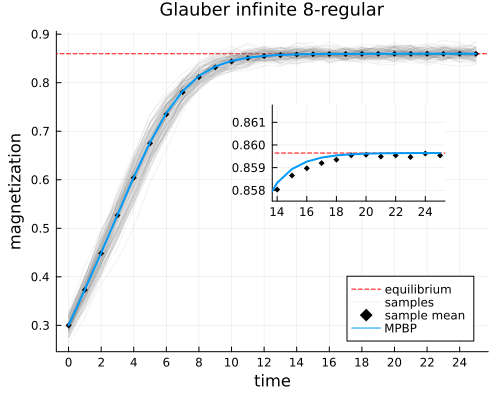

In [334]:
blue = theme_palette(:auto)[1]
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium")
plot!(pl, 0:T, sample(m_mc, 10^2), label=permutedims(["samples"; fill("", 10^2-1)]), c=:gray, la=0.1)
plot!(pl, 0:T, mean(m_mc), label="sample mean", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)
pl = plot!(pl, 0:T, m, xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
    legend=:bottomright, msc=:auto, c=blue, lw=2)

ylims = m_eq .+ 2e-3 .* (-1,1)
plot!(pl, xticks=14:2:T, ylims=ylims, xlims=(14,T),
    inset=(1, bbox(0.5, 0.23, 0.4, 0.3)), subplot=2#=, yticks=LinRange(ylims...,3)=#)
hline!(pl[2], [m_eq], c=:red, ls=:dash, lw=1, label="")
plot!(pl[2], 0:T, mean(m_mc), c=:black, m=:diamond, ms=3, msc=:auto, label="", st=:scatter)
plot!(pl[2], 0:T, m, ylabel="", label="", ms=3, msc=:auto, widen=true, c=blue, lw=2)


plot!(pl, size=(500, 400))